In [5]:
# Import libraries

# For dl modelling
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# For number crunching
import numpy as np

# For data management
import pandas as pd

# For visualisation
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
data = pd.read_csv(url, sep = ';')

In [3]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [22]:
X = data.drop('residual sugar', axis = 1)
y = data['residual sugar']

In [23]:
scaler = StandardScaler() 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 42)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train.values).float()
y_test = torch.tensor(y_test.values).float()
y_train = y_train[:, None]
y_test = y_test[:, None]

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, shuffle = True, batch_size = 16, drop_last = True)
test_loader = DataLoader(test_data, batch_size = test_data.tensors[0].shape[0])

In [27]:
for X,y in train_loader:
    print(X.shape, y.shape)

torch.Size([16, 11]) torch.Size([16, 1])
torch.Size([16, 11]) torch.Size([16, 1])
torch.Size([16, 11]) torch.Size([16, 1])
torch.Size([16, 11]) torch.Size([16, 1])
torch.Size([16, 11]) torch.Size([16, 1])
torch.Size([16, 11]) torch.Size([16, 1])
torch.Size([16, 11]) torch.Size([16, 1])
torch.Size([16, 11]) torch.Size([16, 1])
torch.Size([16, 11]) torch.Size([16, 1])
torch.Size([16, 11]) torch.Size([16, 1])
torch.Size([16, 11]) torch.Size([16, 1])
torch.Size([16, 11]) torch.Size([16, 1])
torch.Size([16, 11]) torch.Size([16, 1])
torch.Size([16, 11]) torch.Size([16, 1])
torch.Size([16, 11]) torch.Size([16, 1])
torch.Size([16, 11]) torch.Size([16, 1])
torch.Size([16, 11]) torch.Size([16, 1])
torch.Size([16, 11]) torch.Size([16, 1])
torch.Size([16, 11]) torch.Size([16, 1])
torch.Size([16, 11]) torch.Size([16, 1])
torch.Size([16, 11]) torch.Size([16, 1])
torch.Size([16, 11]) torch.Size([16, 1])
torch.Size([16, 11]) torch.Size([16, 1])
torch.Size([16, 11]) torch.Size([16, 1])
torch.Size([16, 

In [32]:
class ANNwine(nn.Module):
    def __init__(self, actfun):
        super().__init__()
        
        self.input = nn.Linear(11, 16)
        
        # Hidden layers
        self.bnorm1 = nn.BatchNorm1d(16)
        self.fc1 = nn.Linear(16, 32)
        self.bnorm2 = nn.BatchNorm1d(32)
        self.fc2 = nn.Linear(32, 32)
        
        # Output layer
        self.output = nn.Linear(32, 1)
        
        self.actfun = actfun
    
    def forward(self, x, doBN):
        actfun = getattr(torch.nn, self.actfun)
        x = actfun()(self.input(x))
        
        if doBN:
            x = self.bnorm1(x)
            x = self.fc1(x)
            x = actfun()(x)
            
            x = self.bnorm2(x)
            x = self.fc2(x)
            x = actfun()(x)
            x = self.output(x)
        else:
            x = actfun()(self.fc1(x))
            x = actfun()(self.fc2(x))
            x = self.output(x)
        
        return x

In [33]:
x = torch.randn(100, 11)
net = ANNwine('ReLU')
yHat = net(x, True)
print(yHat.shape)

torch.Size([100, 1])


In [34]:
def create_model(actfun):
    model = ANNwine(actfun)
    lossfun = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.05)
    return model, lossfun, optimizer

In [50]:
numepochs = 1000
def train_model(model, lossfun, optimizer, doBN):
    train_loss = []
    test_loss = []
    
    for epochi in range(numepochs):
        batch_loss = []
        
        for X, y in train_loader:
            yHat = model(X, doBN)
            loss = lossfun(yHat, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_loss.append(loss.item())
            
        train_loss.append(np.mean(batch_loss))
        
        model.eval()
        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = model(X, doBN)
        test_loss.append(lossfun(yHat, y).item())
        model.train()
        
    return train_loss, test_loss

In [60]:
activation_functions = ['ReLU6', 'LeakyReLU', 'ReLU']

trainAct_loss = np.zeros((numepochs, len(activation_functions)))
testAct_loss = np.zeros((numepochs, len(activation_functions)))

for i, act in enumerate(activation_functions):
    model, lossfun, optimizer = create_model(act)
    train_loss, test_loss = train_model(model, lossfun, optimizer, True)
    
    trainAct_loss[:, i] = train_loss
    testAct_loss[:, i] = test_loss

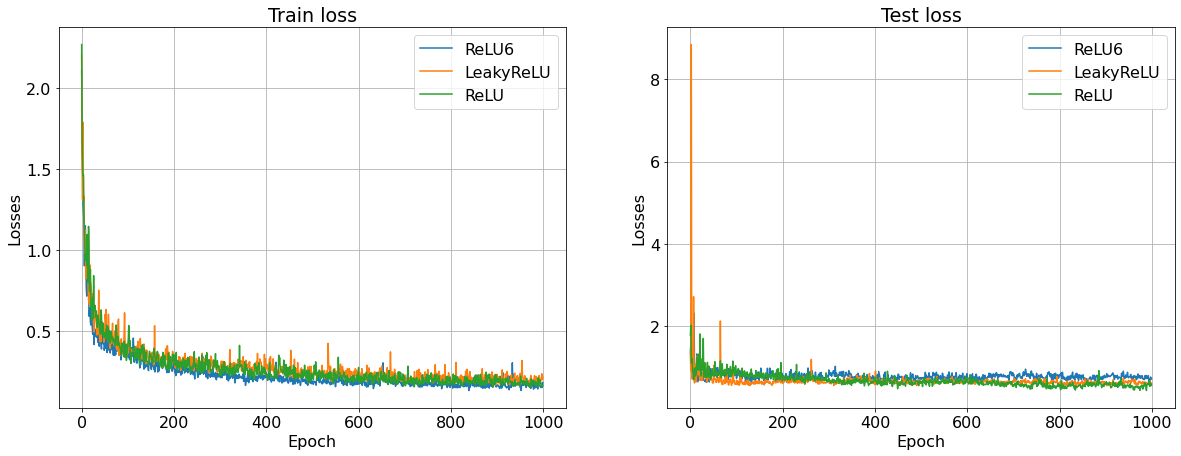

In [61]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(20,7))

ax[0].plot(trainAct_loss)
ax[0].set_title('Train loss')
ax[1].plot(testAct_loss)
ax[1].set_title('Test loss')

# common features
for i in range(2):
  ax[i].legend(activation_functions)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Losses')
  ax[i].grid()

plt.show()

In [62]:
print(trainAct_loss)

[[2.10987396 2.20459773 2.27034157]
 [1.76361656 1.59642124 1.69717712]
 [1.55256956 1.31363342 1.5006866 ]
 ...
 [0.15283098 0.23782536 0.16931123]
 [0.15649872 0.20036913 0.15806492]
 [0.18402236 0.2162057  0.16536825]]


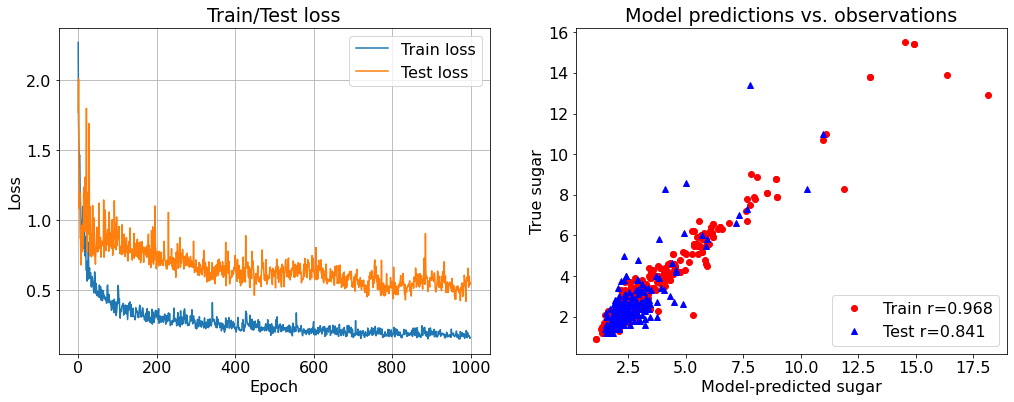

In [66]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(17,6))

ax[0].plot(train_loss,label='Train loss')
ax[0].plot(test_loss,label='Test loss')
ax[0].set_title('Train/Test loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid()


# show predictions and real values
yHatTrain = model(X_train, True)
yHatTest  = model(X_test, True)

ax[1].plot(yHatTrain.detach(),y_train,'ro')
ax[1].plot(yHatTest.detach(), y_test,'b^')
ax[1].set_xlabel('Model-predicted sugar')
ax[1].set_ylabel('True sugar')
ax[1].set_title('Model predictions vs. observations')

# correlations between predictions and outputs
corrTrain = np.corrcoef(yHatTrain.detach().T, y_train.T)[1,0]
corrTest  = np.corrcoef(yHatTest.detach().T, y_test.T)[1,0]
ax[1].legend([ f'Train r={corrTrain:.3f}',f'Test r={corrTest:.3f}' ])

plt.show()

In [64]:
print(yHatTrain)

tensor([[2.8161],
        [1.7387],
        [1.7597],
        ...,
        [2.3430],
        [2.0584],
        [2.5367]], grad_fn=<AddmmBackward0>)


In [65]:
print(yHatTrain.detach())

tensor([[2.8161],
        [1.7387],
        [1.7597],
        ...,
        [2.3430],
        [2.0584],
        [2.5367]])


In [68]:
print(np.corrcoef(yHatTrain.detach().T, y_train.T))

[[1.         0.96823286]
 [0.96823286 1.        ]]


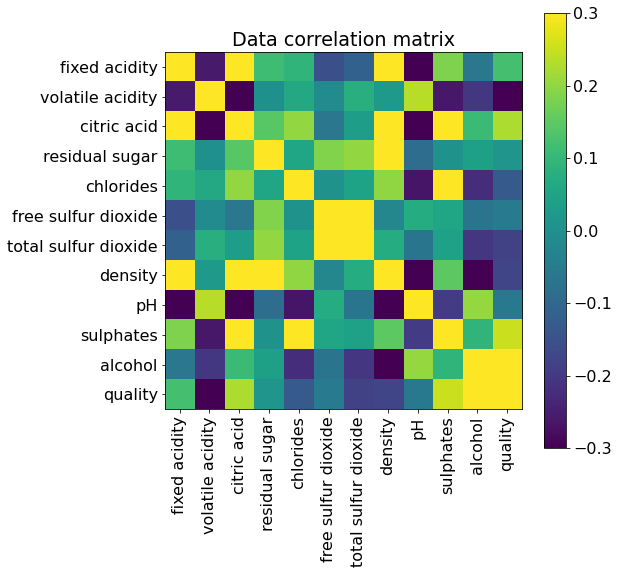

In [70]:
# Inspect the correlation matrix
fig = plt.figure(figsize=(8,8))

plt.imshow(np.corrcoef(data.T),vmin=-.3,vmax=.3)
plt.xticks(range(len(data.keys())),labels=data.keys(),rotation=90)
plt.yticks(range(len(data.keys())),labels=data.keys())
plt.colorbar()
plt.title('Data correlation matrix')
plt.show()

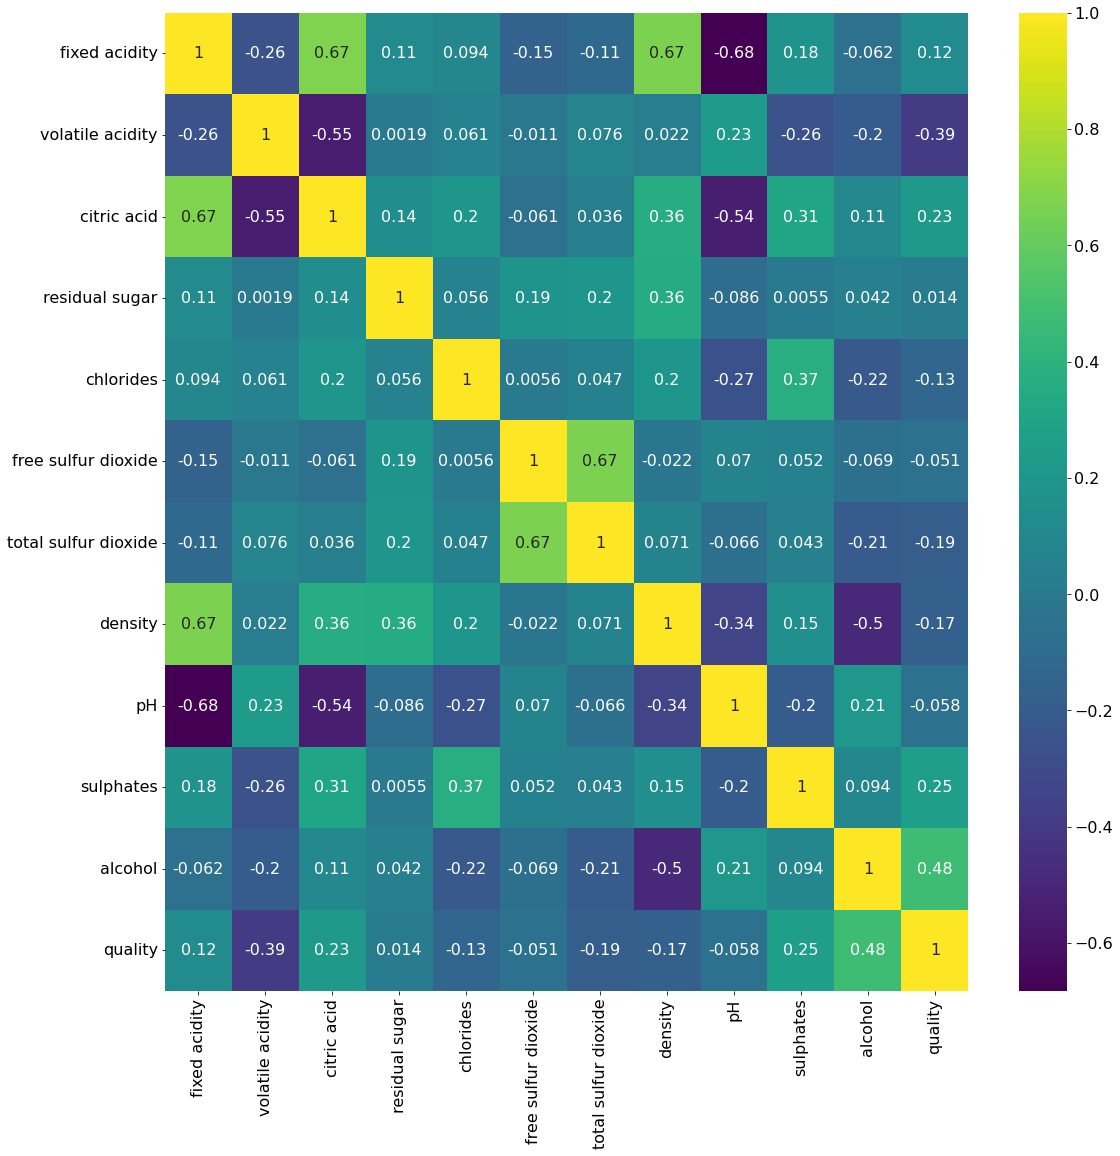

In [75]:
import seaborn as sns
plt.figure(figsize = (18, 18))
sns.heatmap(data.corr(), annot = True, cmap = 'viridis');